<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Test-bit-error-rate-(BER)-versus-signal-to-noise-ratio-per-bit-($E_b/N_0$)" data-toc-modified-id="Test-bit-error-rate-(BER)-versus-signal-to-noise-ratio-per-bit-($E_b/N_0$)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Test bit-error-rate (BER) versus signal-to-noise ratio per bit ($E_b/N_0$)</a></span><ul class="toc-item"><li><span><a href="#QAM-constellations-with-Gray-mapping" data-toc-modified-id="QAM-constellations-with-Gray-mapping-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>QAM constellations with Gray mapping</a></span></li><li><span><a href="#PSK-constellations-with-Gray-mapping" data-toc-modified-id="PSK-constellations-with-Gray-mapping-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>PSK constellations with Gray mapping</a></span></li></ul></li><li><span><a href="#Test-generalized-mutual-information-(GMI)-versus-signal-to-noise-ratio-(SNR)" data-toc-modified-id="Test-generalized-mutual-information-(GMI)-versus-signal-to-noise-ratio-(SNR)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test generalized mutual information (GMI) versus signal-to-noise ratio (SNR)</a></span><ul class="toc-item"><li><span><a href="#QAM-constellations-with-Gray-mapping" data-toc-modified-id="QAM-constellations-with-Gray-mapping-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>QAM constellations with Gray mapping</a></span></li><li><span><a href="#PSK-constellations-with-Gray-mapping" data-toc-modified-id="PSK-constellations-with-Gray-mapping-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>PSK constellations with Gray mapping</a></span></li></ul></li><li><span><a href="#Test-mutual-information-(MI)-versus-signal-to-noise-ratio-(SNR)" data-toc-modified-id="Test-mutual-information-(MI)-versus-signal-to-noise-ratio-(SNR)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test mutual information (MI) versus signal-to-noise ratio (SNR)</a></span><ul class="toc-item"><li><span><a href="#QAM-constellations-with-Gray-mapping" data-toc-modified-id="QAM-constellations-with-Gray-mapping-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>QAM constellations with Gray mapping</a></span></li></ul></li><li><span><a href="#Test-MI/GMI-versus-signal-to-noise-ratio-(SNR)-with-probabilistically-shaped-QAM-constellation" data-toc-modified-id="Test-MI/GMI-versus-signal-to-noise-ratio-(SNR)-with-probabilistically-shaped-QAM-constellation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test MI/GMI versus signal-to-noise ratio (SNR) with probabilistically shaped QAM constellation</a></span></li><li><span><a href="#Test-error-vector-magnitude-(EVM)-versus-signal-to-noise-ratio-(SNR)" data-toc-modified-id="Test-error-vector-magnitude-(EVM)-versus-signal-to-noise-ratio-(SNR)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Test error vector magnitude (EVM) versus signal-to-noise ratio (SNR)</a></span></li><li><span><a href="#Test-OSNR/SNR-prediction-with-the-Gaussian-Noise-model-(GN-Model)-as-a-function-of-the-fiber-input-power" data-toc-modified-id="Test-OSNR/SNR-prediction-with-the-Gaussian-Noise-model-(GN-Model)-as-a-function-of-the-fiber-input-power-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test OSNR/SNR prediction with the Gaussian Noise model (GN Model) as a function of the fiber input power</a></span></li><li><span><a href="#Test-OSNR/SNR-prediction-with-for-a-linear-fiber-channel-as-a-function-of-the-distance" data-toc-modified-id="Test-OSNR/SNR-prediction-with-for-a-linear-fiber-channel-as-a-function-of-the-distance-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Test OSNR/SNR prediction with for a linear fiber channel as a function of the distance</a></span></li></ul></div>

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

In [2]:
from optic.comm.modulation import modulateGray, GrayMapping
from optic.comm.metrics import monteCarloGMI, monteCarloMI, fastBERcalc, theoryBER, calcEVM
from optic.models.channels import awgn
from optic.dsp.core import pnorm, signal_power
from optic.plot import pconst
from optic.core import parameters
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from tqdm.notebook import tqdm
from numba import njit

In [3]:
%load_ext autoreload
%autoreload 2
#%load_ext line_profiler

## Test bit-error-rate (BER) versus signal-to-noise ratio per bit ($E_b/N_0$)

### QAM constellations with Gray mapping

In [4]:
# Run BER vs Ebn0 Monte Carlo simulation in the AWGN channel

qamOrder  = [4, 16, 64, 256, 1024, 4096]  # Modulation order

EbN0dB_  = np.arange(-2, 35, 1)
BER      = np.zeros((len(EbN0dB_),len(qamOrder)))
BER[:]   = np.nan

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)
    for indSNR in tqdm(range(EbN0dB_.size)):

        EbN0dB = EbN0dB_[indSNR]

        # generate random bits
        bitsTx = np.random.randint(2, size=int(np.log2(M)*1e5))    

        # Map bits to constellation symbols
        symbTx = modulateGray(bitsTx, M, 'qam')

        # Normalize symbols energy to 1
        symbTx = pnorm(symbTx) 

        # AWGN channel  
        snrdB  = EbN0dB + 10*np.log10(np.log2(M))
        symbRx = awgn(symbTx, snrdB)

        # BER calculation
        BER[indSNR, ii], _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')

        if BER[indSNR, ii] == 0:              
            break

run sim: M =  4


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  16


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  64


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  256


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  1024


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  4096


  0%|          | 0/37 [00:00<?, ?it/s]

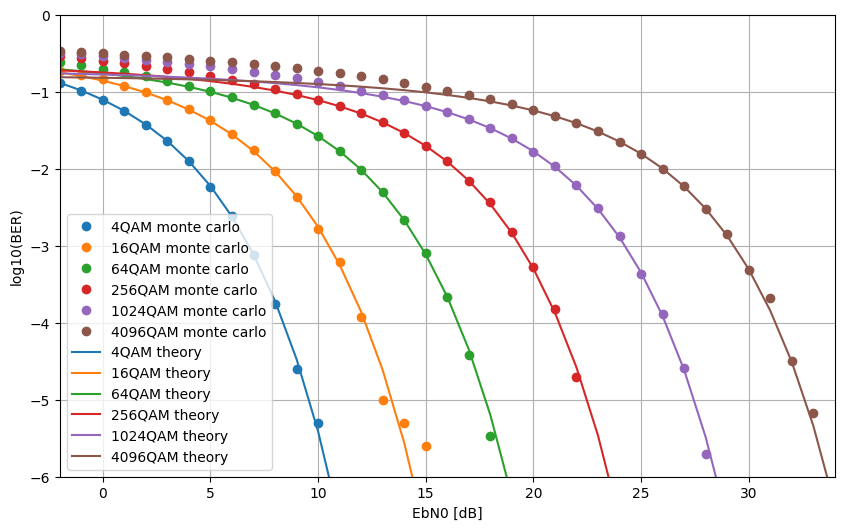

In [5]:
# Plot simulation results and theoretical curves        
BER[BER==0] = np.nan

plt.figure(figsize=(10,6))
for ii, M in enumerate(qamOrder):
    plt.plot(EbN0dB_, np.log10(BER[:,ii]), 'o', label=f'{str(M)}QAM monte carlo')

plt.gca().set_prop_cycle(None)

for M in qamOrder:
    BERtheory = theoryBER(M, EbN0dB_,'qam')
    BERtheory[BERtheory==0] = np.nan
    plt.plot(EbN0dB_, np.log10(BERtheory), '-', label=f'{str(M)}QAM theory')

plt.xlim(min(EbN0dB_), max(EbN0dB_))
plt.ylim(-6, 0)
plt.legend();
plt.xlabel('EbN0 [dB]');
plt.ylabel('log10(BER)');
plt.grid()

### PSK constellations with Gray mapping

In [6]:
# Run BER vs Ebn0 Monte Carlo simulation 

pskOrder  = [4, 8, 16, 32, 64]  # Modulation order

EbN0dB_  = np.arange(-2, 35, 1)
BER      = np.zeros((len(EbN0dB_),len(pskOrder)))
BER[:]   = np.nan

for ii, M in enumerate(pskOrder):
    print('run sim: M = ', M)
    for indSNR in tqdm(range(EbN0dB_.size)):

        EbN0dB = EbN0dB_[indSNR]

        # generate random bits
        bitsTx = np.random.randint(2, size=int(np.log2(M)*1e5))    

        # Map bits to constellation symbols
        symbTx = modulateGray(bitsTx, M, 'psk')

        # Normalize symbols energy to 1
        symbTx = pnorm(symbTx) 

        # AWGN channel  
        snrdB  = EbN0dB + 10*np.log10(np.log2(M))
        symbRx = awgn(symbTx, snrdB)

        # BER calculation
        BER[indSNR, ii], _, _ = fastBERcalc(symbRx, symbTx, M, 'psk')

        if BER[indSNR, ii] == 0:              
            break

run sim: M =  4


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  8


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  16


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  32


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  64


  0%|          | 0/37 [00:00<?, ?it/s]

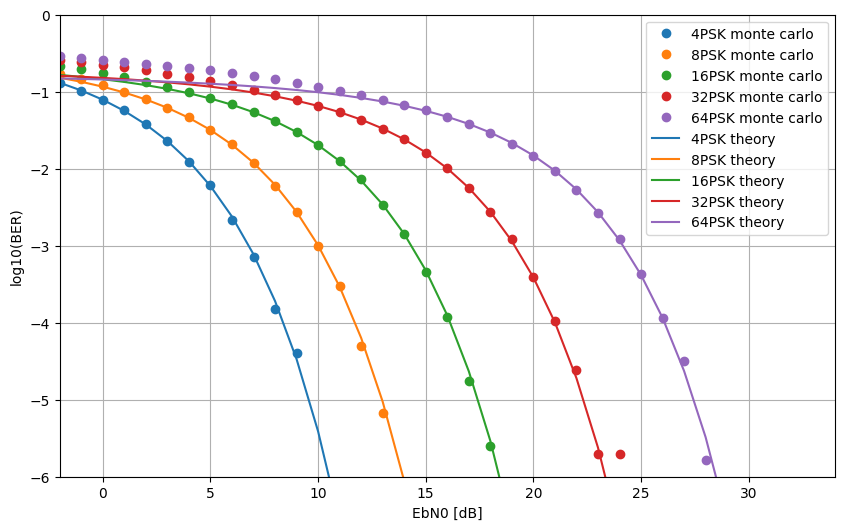

In [7]:
# Plot simulation results and theoretical curves        
BER[BER==0] = np.nan

plt.figure(figsize=(10,6))
for ii, M in enumerate(pskOrder):
    plt.plot(EbN0dB_, np.log10(BER[:,ii]), 'o', label=f'{str(M)}PSK monte carlo')

plt.gca().set_prop_cycle(None)

for M in pskOrder:
    BERtheory = theoryBER(M, EbN0dB_,'psk')
    BERtheory[BERtheory==0] = np.nan
    plt.plot(EbN0dB_, np.log10(BERtheory), '-', label=f'{str(M)}PSK theory')

plt.xlim(min(EbN0dB_), max(EbN0dB_))
plt.ylim(-6, 0)
plt.legend();
plt.xlabel('EbN0 [dB]');
plt.ylabel('log10(BER)');
plt.grid()

## Test generalized mutual information (GMI) versus signal-to-noise ratio (SNR)

### QAM constellations with Gray mapping

In [8]:
# Run GMI vs SNR Monte Carlo simulation 

qamOrder  = [4, 16, 64, 256, 1024, 4096]  # Modulation order

SNR  = np.arange(-2, 35, 1)
GMI  = np.zeros((len(SNR),len(qamOrder)))

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)
    for indSNR in tqdm(range(SNR.size)):

        snrdB = SNR[indSNR]

        # generate random bits
        bitsTx   = np.random.randint(2, size=int(np.log2(M)*1e5))    

        # Map bits to constellation symbols
        symbTx = modulateGray(bitsTx, M, 'qam')

        # Normalize symbols energy to 1
        symbTx = pnorm(symbTx) 

        # AWGN channel       
        symbRx = awgn(symbTx, snrdB)

        # GMI estimation
        GMI[indSNR, ii], _  = monteCarloGMI(symbRx, symbTx, M, 'qam')

run sim: M =  4


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  16


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  64


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  256


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  1024


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  4096


  0%|          | 0/37 [00:00<?, ?it/s]

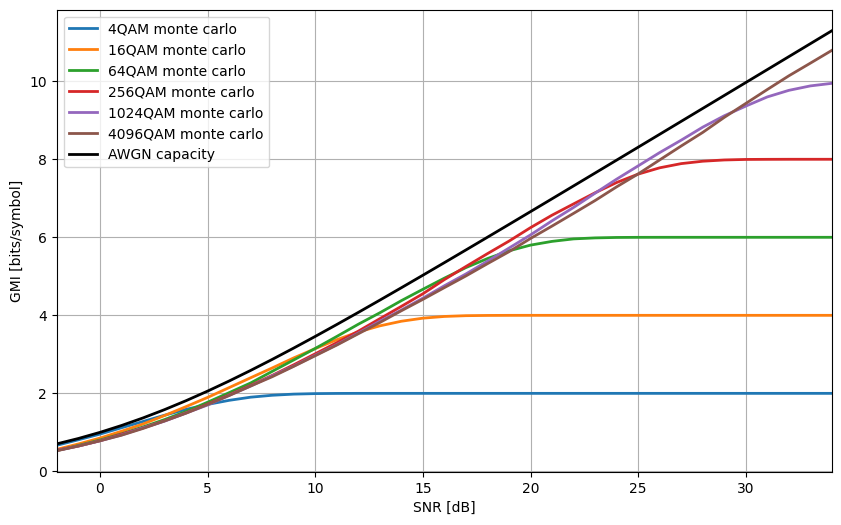

In [9]:
plt.figure(figsize=(10,6))
for ii, M in enumerate(qamOrder):
    plt.plot(SNR, GMI[:,ii], '-', label=f'{str(M)}QAM monte carlo', linewidth=2)

# plot theoretical AWGN channel capacity    
C = np.log2(1 + 10**(SNR/10))
plt.plot(SNR, C,'k-', label='AWGN capacity',linewidth=2)


plt.xlim(min(SNR), max(SNR))
plt.legend();
plt.xlabel('SNR [dB]');
plt.ylabel('GMI [bits/symbol]');
plt.grid()

### PSK constellations with Gray mapping

In [10]:
# Run GMI vs SNR Monte Carlo simulation 

pskOrder  = [4, 8, 16, 32, 64]  # Modulation order

SNR  = np.arange(-2, 35, 1)
GMI  = np.zeros((len(SNR),len(pskOrder)))

for ii, M in enumerate(pskOrder):
    print('run sim: M = ', M)
    for indSNR in tqdm(range(SNR.size)):

        snrdB = SNR[indSNR]

        # generate random bits
        bitsTx   = np.random.randint(2, size=int(np.log2(M)*1e4))    

        # Map bits to constellation symbols
        symbTx = modulateGray(bitsTx, M, 'psk')

        # Normalize symbols energy to 1
        symbTx = pnorm(symbTx) 

        # AWGN channel       
        symbRx = awgn(symbTx, snrdB)

        # GMI estimation
        GMI[indSNR, ii], _  = monteCarloGMI(symbRx, symbTx, M, 'psk')

run sim: M =  4


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  8


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  16


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  32


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  64


  0%|          | 0/37 [00:00<?, ?it/s]

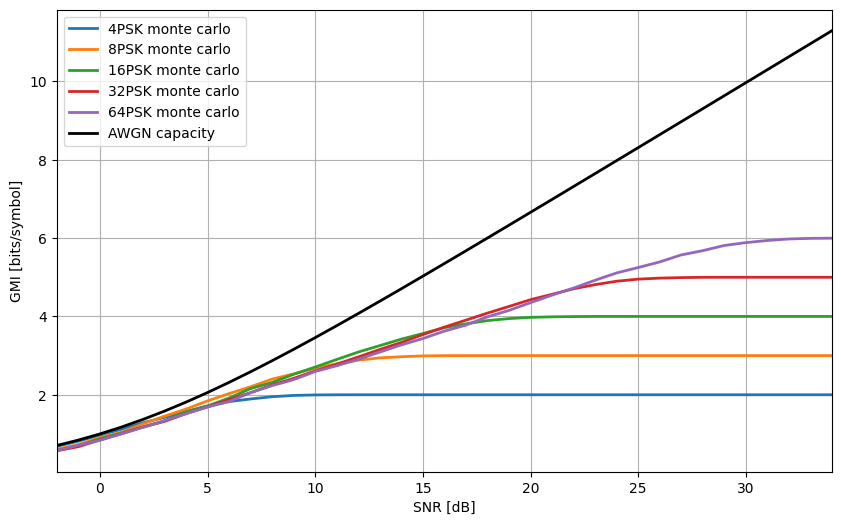

In [11]:
plt.figure(figsize=(10,6))
for ii, M in enumerate(pskOrder):
    plt.plot(SNR, GMI[:,ii], '-', label=f'{str(M)}PSK monte carlo', linewidth=2)

# plot theoretical AWGN channel capacity    
C = np.log2(1 + 10**(SNR/10))
plt.plot(SNR, C,'k-', label='AWGN capacity',linewidth=2)


plt.xlim(min(SNR), max(SNR))
plt.legend();
plt.xlabel('SNR [dB]');
plt.ylabel('GMI [bits/symbol]');
plt.grid()

## Test mutual information (MI) versus signal-to-noise ratio (SNR)

### QAM constellations with Gray mapping

In [12]:
# Run MI vs SNR Monte Carlo simulation 

qamOrder  = [4, 16, 64, 256, 1024]  # Modulation order

SNR  = np.arange(-2, 35, 1)
MI  = np.zeros((len(SNR),len(qamOrder)))

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)         

    for indSNR in tqdm(range(SNR.size)):

        snrdB = SNR[indSNR]

        # generate random bits
        bitsTx   = np.random.randint(2, size=int(np.log2(M)*1e4))    

        # Map bits to constellation symbols
        symbTx = modulateGray(bitsTx, M, 'qam')

        # Normalize symbols energy to 1
        symbTx = pnorm(symbTx) 

        # AWGN channel        
        symbRx = awgn(symbTx, snrdB)

        # MI estimation
        MI[indSNR, ii] = monteCarloMI(symbRx, symbTx, M, 'qam')

run sim: M =  4


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  16


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  64


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  256


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  1024


  0%|          | 0/37 [00:00<?, ?it/s]

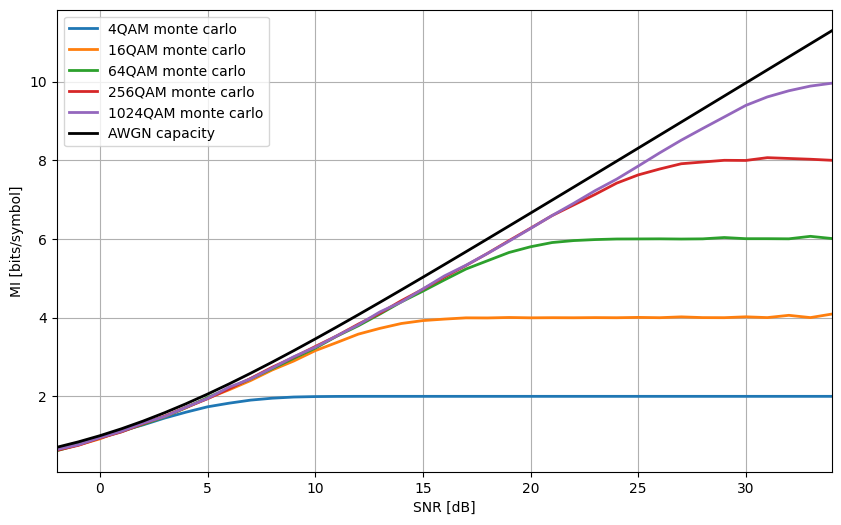

In [13]:
plt.figure(figsize=(10,6))

for ii, M in enumerate(qamOrder):
    plt.plot(SNR, MI[:,ii], '-', label=f'{str(M)}QAM monte carlo', linewidth=2)

# plot theoretical AWGN channel capacity    
C = np.log2(1 + 10**(SNR/10))
plt.plot(SNR, C,'k-', label='AWGN capacity',linewidth=2)


plt.xlim(min(SNR), max(SNR))
plt.legend();
plt.xlabel('SNR [dB]');
plt.ylabel('MI [bits/symbol]');
plt.grid()

## Test MI/GMI versus signal-to-noise ratio (SNR) with probabilistically shaped QAM constellation

In [14]:
from numpy.random import choice

def maxwellBolt(λ, const):
    
    p = np.zeros(const.size)
    
    for ind, x in enumerate(const):
        p[ind] = np.exp(-λ*np.abs(x)**2)
        
    p = p/np.sum(p)
    
    return p   

run sim: M =  256


  0%|          | 0/36 [00:00<?, ?it/s]

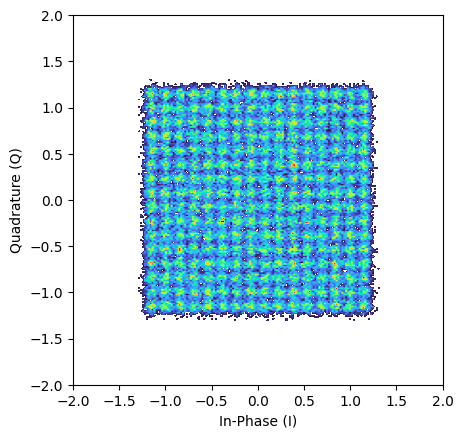

run sim: M =  256


  0%|          | 0/36 [00:00<?, ?it/s]

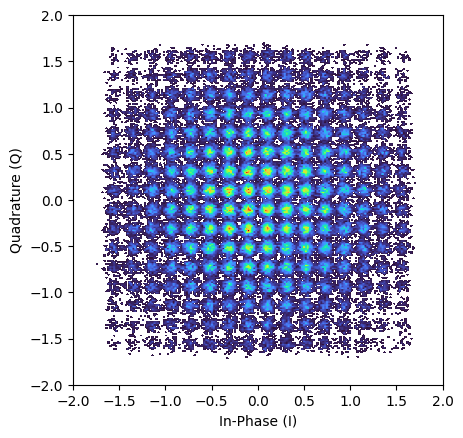

In [15]:
# Run MI vs SNR Monte Carlo simulation 

qamOrder  = [256, 256]  # Modulation order

SNR  = np.arange(-2, 34, 1)
MI = np.zeros((len(SNR),len(qamOrder)))
GMI = np.zeros((len(SNR),len(qamOrder)))
Nsymbols = 80000

PS = 0
for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)

    constSymb = GrayMapping(M, 'qam')
    Es = np.mean(np.abs(constSymb) ** 2)
    constSymb = constSymb / np.sqrt(Es)

    probSymb = maxwellBolt(PS, constSymb)    
    PS = 1.5

    Es = np.sum(( np.abs(constSymb) ** 2 ) * probSymb)

    for indSNR in tqdm(range(SNR.size)):

        snrdB = SNR[indSNR]

        # generate random symbols   
        symbTx = choice(constSymb, Nsymbols, p=probSymb)           

        # AWGN channel       
        symbRx = awgn(symbTx, snrdB)      

        # MI estimation
        MI[indSNR, ii] = monteCarloMI(symbRx, symbTx, M, 'qam', probSymb)  
        GMI[indSNR, ii], _ = monteCarloGMI(symbRx, symbTx, M, 'qam', probSymb)

        if indSNR == len(SNR)-10:
            pconst(symbRx, R=2);

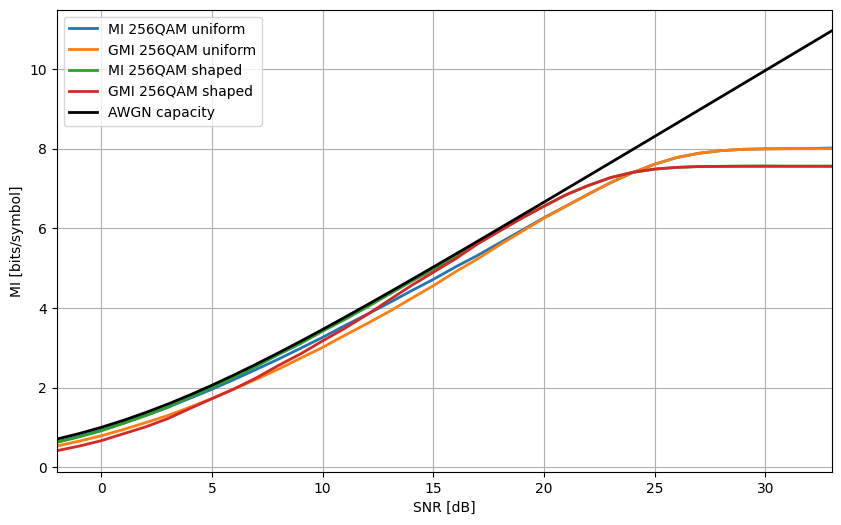

In [16]:
plt.figure(figsize=(10,6))

for ii, M in enumerate(qamOrder):
    pltLabel = 'QAM uniform' if ii == 0 else 'QAM shaped'
    plt.plot(SNR, MI[:,ii], '-', label=f'MI {str(M)}{pltLabel}', linewidth=2)
    plt.plot(SNR, GMI[:,ii], '-', label=f'GMI {str(M)}{pltLabel}', linewidth=2)

# plot theoretical AWGN channel capacity    
C = np.log2(1 + 10**(SNR/10))
plt.plot(SNR, C,'k-', label='AWGN capacity',linewidth=2)


plt.xlim(min(SNR), max(SNR))
plt.legend();
plt.xlabel('SNR [dB]');
plt.ylabel('MI [bits/symbol]');
plt.grid()

## Test error vector magnitude (EVM) versus signal-to-noise ratio (SNR)

In [24]:
# Run EVM vs SNR Monte Carlo simulation 

qamOrder  = [4, 16, 64, 256, 1024]  # Modulation order

SNR  = np.arange(-2, 35, 1)
EVM_dataAided  = np.zeros((len(SNR),len(qamOrder)))
EVM_decisions  = np.zeros((len(SNR),len(qamOrder)))

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)         

    for indSNR in tqdm(range(SNR.size)):

        snrdB = SNR[indSNR]

        # generate random bits
        bitsTx   = np.random.randint(2, size=int(np.log2(M)*1e5))    

        # Map bits to constellation symbols
        symbTx = modulateGray(bitsTx, M, 'qam')

        # Normalize symbols energy to 1
        symbTx = pnorm(symbTx) 

        # AWGN channel        
        symbRx = awgn(symbTx, snrdB)

        # EVM estimation
        EVM_dataAided[indSNR, ii] = calcEVM(symbRx, M, 'qam', symbTx=symbTx)
        EVM_decisions[indSNR, ii] = calcEVM(symbRx, M, 'qam')

run sim: M =  4


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  16


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  64


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  256


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  1024


  0%|          | 0/37 [00:00<?, ?it/s]

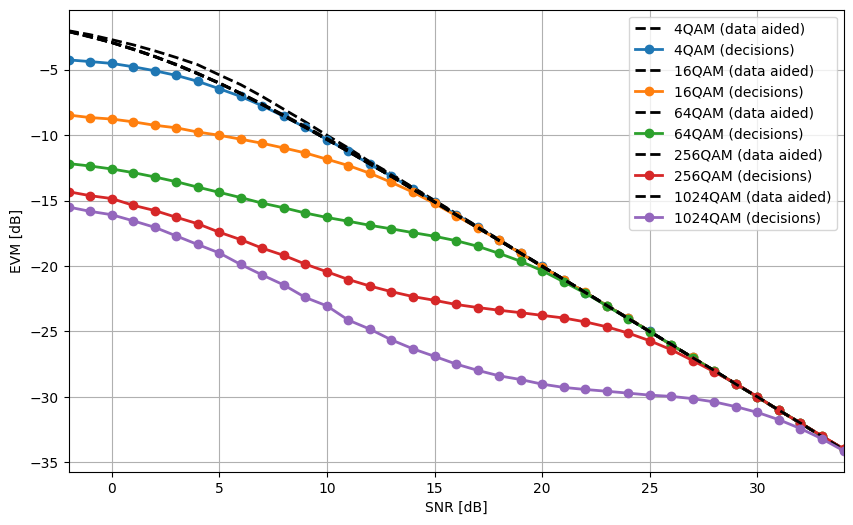

In [25]:
plt.figure(figsize=(10,6))

for ii, M in enumerate(qamOrder):
    plt.plot(SNR, 10*np.log10(EVM_dataAided[:,ii]), '--', color='black', label=f'{str(M)}QAM (data aided)', linewidth=2)
    plt.plot(SNR, 10*np.log10(EVM_decisions[:,ii]), '-o', label=f'{str(M)}QAM (decisions)', linewidth=2)


plt.xlim(min(SNR), max(SNR))
plt.legend();
plt.xlabel('SNR [dB]');
plt.ylabel('EVM [dB]');
plt.grid()

## Test OSNR/SNR prediction with the Gaussian Noise model (GN Model) as a function of the fiber input power

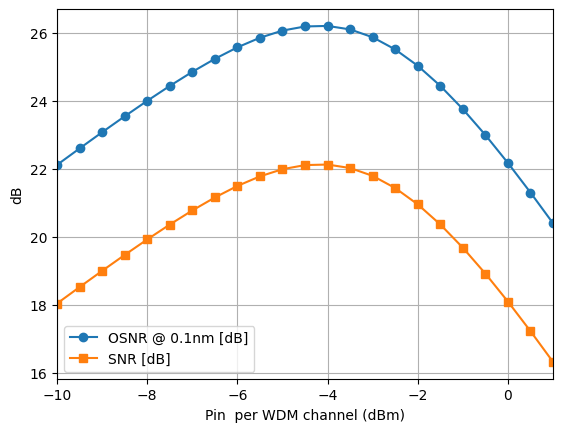

In [26]:
from optic.comm.metrics import GNmodel_OSNR

# optical signal parameters
Nch = 80   # Number of Nyquist-WDM channels
Rs = 32e9  # Symbol-rate
Δf = 37.5e9 # WDM grid spacing in Hz
Bref = 12.5e9 # reference bandwidth for OSNR measurement in Hz

# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 700   # total link distance [km]
paramCh.Lspan  = 50    # span length [km]
paramCh.alpha = 0.2    # fiber loss parameter [dB/km]
paramCh.D = 16         # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3    # fiber nonlinear parameter [1/(W.km)]
paramCh.Fc = 193.1e12  # central optical frequency of the WDM spectrum in Hz

Ptx = np.arange(-10, 1.5, 0.5)

OSNR,_,_ = GNmodel_OSNR(Rs, Nch, Δf, Ptx, paramCh, Bref)

OSNR_dB = 10*np.log10(OSNR)
SNR_dB = OSNR_dB-10*np.log10(Rs/Bref);

plt.plot(Ptx, OSNR_dB,'-o',label='OSNR @ 0.1nm [dB]')
plt.plot(Ptx, SNR_dB,'-s',label='SNR [dB]')
plt.grid()
plt.ylabel('dB')
plt.xlabel('Pin  per WDM channel (dBm)')
plt.legend();
plt.xlim(min(Ptx), max(Ptx));

## Test OSNR/SNR prediction with for a linear fiber channel as a function of the distance

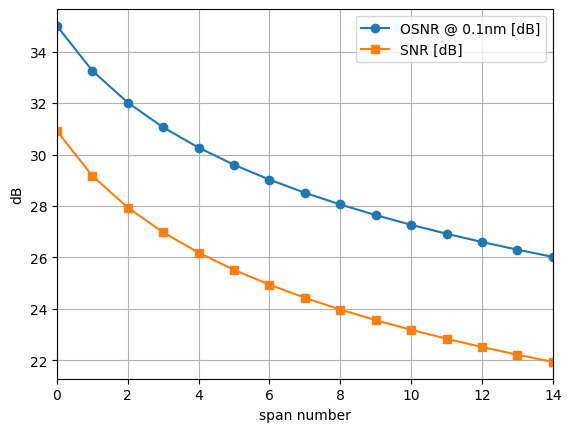

In [27]:
from optic.comm.metrics import calcLinOSNR

Ns = 14       # number of fiber spans
Ls = 50       # span length in km
Rs = 32e9     # symbol-rate
Pin = -4      # launch power per channel in dBm
OSNRin = 35   # launch OSNR in dB
NF = 6        # EDFA noise figure in dB
α = 0.2       # fiber attenuation in dB/km
Fc = 193.1e12 # central optical frequency in Hz
Bref = 12.5e9 # OSNR reference bandwidth in Hz

OSNR_dB = calcLinOSNR(Ns, Pin, α, Ls, OSNRin, NF, Fc, Bref)

SNR_dB = OSNR_dB-10*np.log10(Rs/Bref);

plt.plot(OSNR_dB,'-o',label='OSNR @ 0.1nm [dB]')
plt.plot(SNR_dB,'-s',label='SNR [dB]')
plt.grid()
plt.ylabel('dB')
plt.xlabel('span number')
plt.legend();
plt.xlim(0, Ns);